# Deep Learning with PyTorch : Build a Generative Adversarial Network 

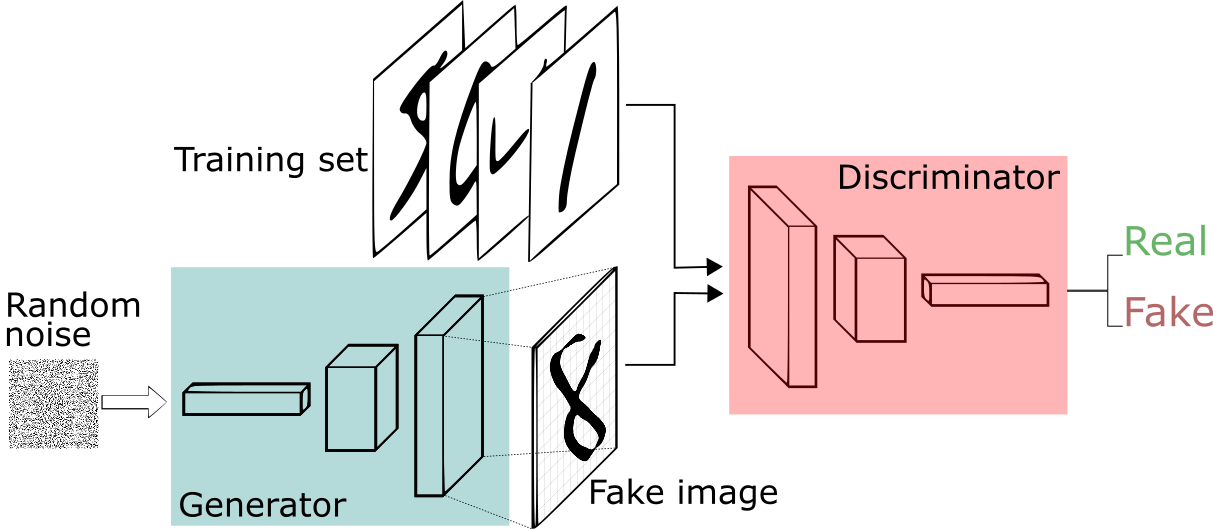

In [2]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

# Yapılandırmalar

In [3]:
device = 'cuda' 
batch_size = 128
noise_dim = 64
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99
epochs = 20

# MNIST Dataset'in yüklenmesi 

In [4]:
from torchvision import datasets, transforms as T

In [5]:
train_augs = T.Compose([
                        T.RandomRotation((-20, +20)),
                        T.ToTensor(),
])

trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



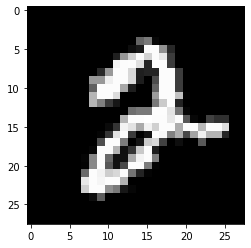

In [7]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap = 'gray')

In [8]:
print('toplam resim sayısı ( trainset )', len(trainset))

toplam resim sayısı ( trainset ) 60000


# Veri kümesini batch'lere yükleme

In [10]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [12]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)

In [14]:
print("toplam batch sayısı (trainloader):", len(trainloader))

toplam batch sayısı (trainloader): 469


In [18]:
dataiter = iter(trainloader)

images, _ = next(dataiter)

print(images.shape)

torch.Size([128, 1, 28, 28])


In [21]:
# 'show_tensor_images' : batch'den bazı görüntüleri çizmek için kullanılır.

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

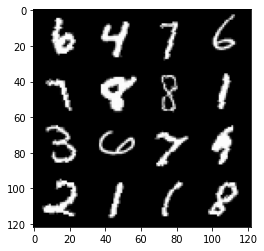

In [22]:
show_tensor_images(images, num_images = 16)

# Discriminator Network 'un oluşturulması

In [23]:
# torcsummary i yüklü değilse

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [25]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [28]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1= get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features=1)

  def forward (self, images):
    
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5



In [29]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Generator Network'ün oluşturulması

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [36]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [41]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, r_noise_vec):

    x = r_noise_vec.view(-1, self.noise_dim, 1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4


In [42]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [43]:
# Rastgele başlatılan ağırlıkları Normal ağırlıklara değiştirelim.  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [44]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Loss Function ve Optimizer

In [45]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [47]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))


# Eğitim döngüsü

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 1 | D_loss: 0.681597742317582 | G_loss: 0.6983254656100324


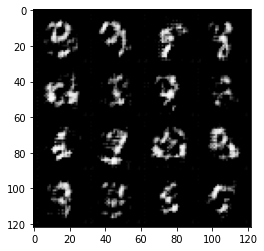

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 2 | D_loss: 0.6786334148602191 | G_loss: 0.7116434608441172


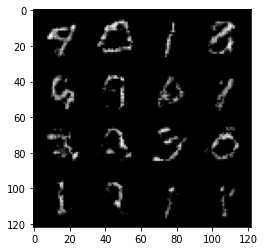

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 3 | D_loss: 0.6391498398170796 | G_loss: 0.7578154363866045


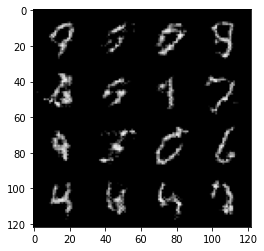

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 4 | D_loss: 0.5834447689402078 | G_loss: 0.8301061550691438


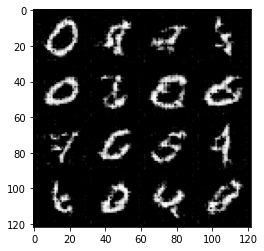

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 5 | D_loss: 0.5501758635425364 | G_loss: 0.8911953790863948


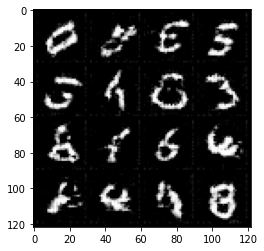

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 6 | D_loss: 0.5422846653949477 | G_loss: 0.9233851864902195


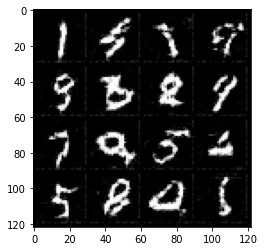

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 7 | D_loss: 0.5465933956317047 | G_loss: 0.9363718237449874


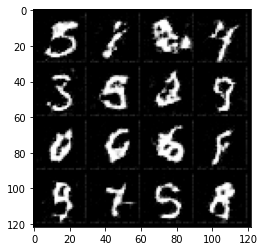

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 8 | D_loss: 0.5591414554286868 | G_loss: 0.9326524847606098


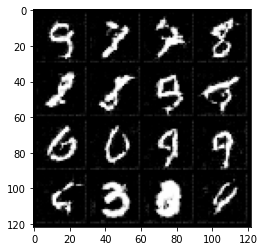

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 9 | D_loss: 0.572408413454922 | G_loss: 0.9238609698281359


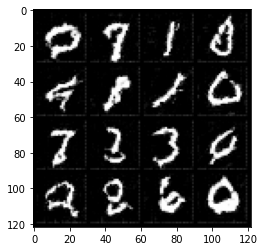

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 10 | D_loss: 0.5845949464261151 | G_loss: 0.9130187171862832


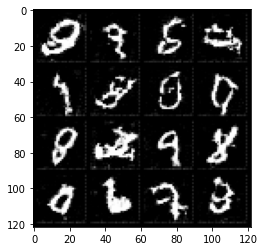

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 11 | D_loss: 0.5934763290226333 | G_loss: 0.8984102036144688


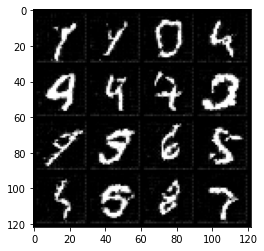

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 12 | D_loss: 0.6024147488160937 | G_loss: 0.893027284760465


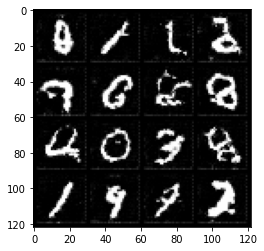

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 13 | D_loss: 0.6069201317423188 | G_loss: 0.8870254029343123


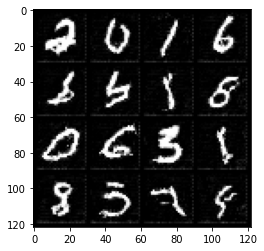

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 14 | D_loss: 0.6120554628148516 | G_loss: 0.8821043087475335


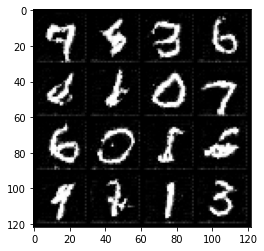

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 15 | D_loss: 0.6163389560764533 | G_loss: 0.8756104175215845


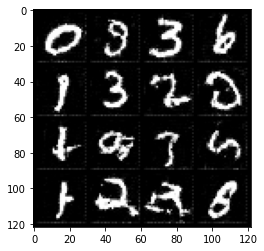

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 16 | D_loss: 0.6180410058513633 | G_loss: 0.8711284453680774


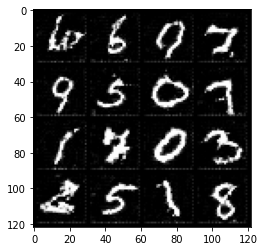

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 17 | D_loss: 0.6204729223810533 | G_loss: 0.8708190715897566


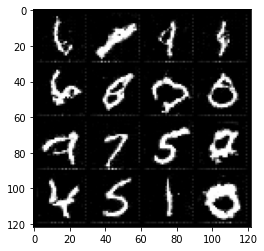

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 18 | D_loss: 0.6220208958013734 | G_loss: 0.8677732883485904


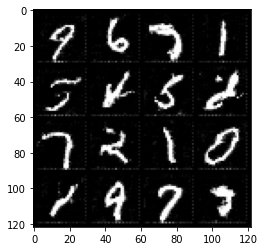

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 19 | D_loss: 0.6238869466761282 | G_loss: 0.8651366156301519


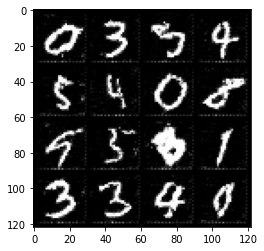

  0%|          | 0/469 [00:00<?, ?it/s]

epochs: 20 | D_loss: 0.6240546974037756 | G_loss: 0.862574371066429


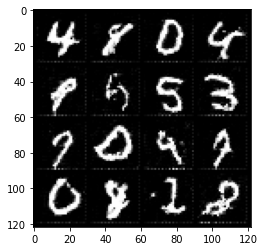

In [49]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()
  ####################################

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()
  
  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader) 

  print("epochs: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

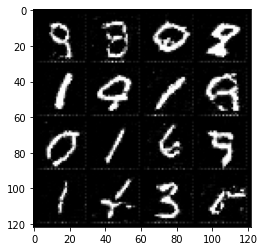

In [50]:
noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)